# Scraping Publications Date, Authors and URLs

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from loguru import logger
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from dateutil import parser as dparse
import pandas as pd
from pathlib import Path

BASE_URL = "https://www.ecb.europa.eu"

def _headless_chrome():
    opts = Options()
    opts.add_argument("--headless=new")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-gpu")
    opts.add_argument("--window-size=1200,2000")
    return webdriver.Chrome(options=opts)

def scroll_until_loaded(driver, timeout=10, max_idle_rounds=3, hard_cap_rounds=200):
    prev_count = len(driver.find_elements(By.CSS_SELECTOR, "dl > dt"))
    idle = 0
    rounds = 0
    while True:
        rounds += 1
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        try:
            WebDriverWait(driver, timeout).until(
                lambda d: len(d.find_elements(By.CSS_SELECTOR, "dl > dt")) > prev_count
            )
            prev_count = len(driver.find_elements(By.CSS_SELECTOR, "dl > dt"))
            idle = 0
        except:
            idle += 1
        if idle >= max_idle_rounds or rounds >= hard_cap_rounds:
            break

def parse_page(html: str):
    soup = BeautifulSoup(html, "html.parser")

    # Get the OUTER (top-level) <dl>. We take the first <dl> in the main content.
    dl = soup.select_one("dl")
    if dl is None:
        return []

    # Iterate top-level siblings: pair each <dt> with its immediate <dd>
    items = []
    node = dl.find("dt")
    while node:
        if node.name == "dt":
            dt_tag = node
            dd_tag = dt_tag.find_next_sibling("dd")
            if dd_tag and dd_tag.parent == dl:
                # Extract fields
                date_raw = dt_tag.get_text(strip=True)
                try:
                    date_iso = dparse.parse(date_raw, dayfirst=False).date().isoformat()
                except Exception:
                    date_iso = date_raw  # fallback to raw if parsing fails

                cat = dd_tag.select_one("div.category")
                category = (cat.get_text(strip=True) if cat else None)

                a = dd_tag.select_one("div.title a")
                title = a.get_text(strip=True) if a else None
                href = a["href"] if a and a.has_attr("href") else None
                url = urljoin(BASE_URL, href) if href else None

                # Authors (if present)
                author_nodes = dd_tag.select("div.authors li")
                authors = [li.get_text(strip=True) for li in author_nodes] if author_nodes else []

                items.append(
                    {
                        "date": date_iso,
                        "category": category,
                        "title": title,
                        "url": url,
                        "authors": authors,
                    }
                )
            node = dd_tag.find_next_sibling() if dd_tag else node.find_next_sibling()
        else:
            node = node.find_next_sibling()
    return items

def get_url(filter_type, value: str): 
    index_html = "https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?"
    return f"{index_html}{filter_type}={value.replace(' ', '%20')}"

def scrape_ecb_pub(filter_type, filter_value, save_csv: str = None,) -> pd.DataFrame:
    driver = _headless_chrome()
    url = get_url(filter_type, filter_value)
    try:
        driver.get(url)
        WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "dl > dt")))
        scroll_until_loaded(driver)
        data = parse_page(driver.page_source)
        df = pd.DataFrame(data, columns=["date", "category", "title", "url", "authors"])
        df['filter_type'] = filter_type
        df['filter_value'] = filter_value
        if save_csv:
            df.to_csv(save_csv, index=False)
        logger.success(f"Successfully scraped: {url}, rows: {df.shape}")
        return df
    except Exception as e: 
        logger.warning(f"Failed {filter_type} {filter_value}: {url}: {e}")
    finally:
        driver.quit()

In [2]:
topics = [
    "Accountability",
    "Asset purchase programme (APP)",
    "Bank failure",
    "Bank profitability",
    "Bank resolution",
    "Banking regulation",
    "Banking sector",
    "Banking supervision",
    "Banking union",
    "Banknotes and coins",
    "Basel III",
    "Benchmark rates",
    "Bitcoin",
    "Brexit",
    "Capital key",
    "Capital markets union",
    "Central bank digital currencies (CBDC)",
    "Central bank independence",
    "Central banking",
    "Central counterparties (CCPs)",
    "Climate change",
    "Collateral",
    "Communication",
    "Coronavirus",
    "Crypto-assets",
    "Currencies",
    "Cyber resilience",
    "Deposit facility rate",
    "Digital euro",
    "Digitalisation",
    "Distributed ledger technology (DLT)",
    "Diversity and inclusion",
    "Economic and Monetary Union (EMU)",
    "Economic development",
    "Emergency liquidity assistance (ELA)",
    "Euro",
    "Euro area",
    "Euro overnight index average (EONIA)",
    "Euro short-term rate (€STR)",
    "European integration",
    "Excess reserves",
    "Exchange rates",
    "Financial assets",
    "Financial crisis",
    "Financial integration",
    "Financial market infrastructures",
    "Financial markets",
    "Financial stability",
    "Fintech",
    "Fiscal policy",
    "Forward guidance",
    "Governance",
    "Haircuts",
    "History of the euro",
    "Inflation",
    "Innovation",
    "Instant payments",
    "Interest rates",
    "International relations",
    "International role of the euro",
    "Key ECB interest rates",
    "Labour market",
    "Legal framework",
    "Liquidity",
    "Liquidity lines",
    "Macroprudential policy",
    "Main refinancing operations (MRO) rate",
    "Marginal lending facility rate",
    "Microprudential policy",
    "Minimum reserve requirements",
    "Monetary policy",
    "Money",
    "Non-performing loans",
    "Outright Monetary Transactions (OMTs)",
    "Pandemic emergency longer-term refinancing operations (PELTROs)",
    "Pandemic emergency purchase programme (PEPP)",
    "Payment systems",
    "Policies",
    "Price stability",
    "Profits",
    "Protectionism",
    "Repo lines",
    "Resilience",
    "Risks",
    "Rules and procedures",
    "Russia-Ukraine war",
    "Russian war against Ukraine",
    "Sanctions",
    "Securities",
    "Statistics and data",
    "Strategy review",
    "Stress tests",
    "Structural reforms",
    "Swap lines",
    "TARGET Instant Payment Settlement (TIPS)",
    "TARGET2",
    "Targeted longer-term refinancing operations (TLTROs)",
    "Technology",
    "Trade",
    "Transmission Protection Instrument (TPI)",
    "Two-tier system",
    "Uncertainties",]

for topic in topics:
    save_path = Path(r"data\blogs_articles\topics") / f"ecb_published_{topic}.csv"
    if not save_path.exists():
        logger.warning(f"Topic {topic} does not exist yet, scraping the publications list from the url.")
        df = scrape_ecb_pub(filter_type='topic', filter_value=topic, save_csv=f"ecb_published_{topic}.csv")

In [3]:
all_links = pd.concat([pd.read_csv(Path(f"data/blogs_articles/topics/ecb_published_{topic}.csv")) for topic in topics])

# Downloading the HTMLs from the URLs

In [4]:
all_links = (
    all_links
    .groupby(["date", "category", "title", "authors","filter_type","url"], as_index=False)
    .agg({"filter_value": lambda x: list(set(x))})
)
all_links['url_hash'] = all_links['url'].apply(lambda x: str(hash(x) & ((1<<64)-1)))

In [ ]:
from pathlib import Path
import pandas as pd
import requests
import time, random
from pathlib import Path
import requests
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from tqdm import tqdm

def make_session():
    s = requests.Session()
    s.headers.update({
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/124.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en,de;q=0.9",
    })
    retry = Retry(
        total=6,                # total retry attempts
        connect=3,              # connection retries
        read=3,                 # read retries
        status=6,               # status code retries
        backoff_factor=0.8,     # exponential backoff (respects Retry-After)
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods={"HEAD", "GET", "OPTIONS"},
        raise_on_status=False,
        respect_retry_after_header=True,
    )
    adapter = HTTPAdapter(max_retries=retry, pool_connections=50, pool_maxsize=50)
    s.mount("http://", adapter)
    s.mount("https://", adapter)
    return s

html_dir = Path("data/blogs_articles/topics_html")
html_dir.mkdir(parents=True, exist_ok=True)
overview_path = html_dir / "topics_html_downloaded_overview.csv"

if overview_path.exists(): 
    all_links_downloaded = pd.read_csv(overview_path)
else: 
    session = make_session()

    rows, indices = [], []
    for index, row in tqdm(all_links.iterrows(), total=all_links.shape[0]):
        row = row.to_dict()
        url = row.get("url")
        out_path = html_dir / f"{row.get('url_hash')}.html"

        html_downloaded = False
        err = None

        try:
            time.sleep(random.uniform(0.05, 0.25))
            r = session.get(url, timeout=(5, 20), allow_redirects=True)
            if r.status_code == 200:
                out_path.write_text(r.text, encoding=r.encoding or "utf-8", errors="ignore")
                html_downloaded = True
            else:
                err = f"HTTP {r.status_code}"
        except requests.RequestException as e:
            err = str(e)[:300]

        row["html_downloaded"] = html_downloaded
        if err is not None:
            row["download_error"] = err

        indices.append(index)
        rows.append(row)


    all_links_downloaded = pd.DataFrame.from_records(rows, index = indices)
    all_links_downloaded.to_csv(overview_path)

In [6]:
all_links

,date,category,title,authors,filter_type,url,filter_value,url_hash
0,1997-04-25,Press release,"""EUR"" - the new currency code for the euro",[],topic,https://www.ecb.europa.eu/press/pr/date/1997/h...,[Central banking],13700031738230128916
1,1997-07-01,Press release,Change of presidency of the European Monetary ...,[],topic,https://www.ecb.europa.eu/press/pr/date/1997/h...,[Central banking],292201502917343138
2,1997-07-02,Press release,Selection and further development of the euro ...,[],topic,https://www.ecb.europa.eu/press/pr/date/1997/h...,[Central banking],8803076416667206106
3,1997-07-02,Press release,The EMI's mandate with respect to banknotes,[],topic,https://www.ecb.europa.eu/press/pr/date/1997/h...,[Central banking],11563394610509288921
4,1997-07-02,Press release,The euro banknotes and the partially sighted,[],topic,https://www.ecb.europa.eu/press/pr/date/1997/h...,[Central banking],17807499730590618928
...,...,...,...,...,...,...,...,...
4780,2025-07-31,The ECB Blog,The ripple effects of monetary policy on housi...,"['Niccolò Battistini', 'Johannes Gareis']",topic,https://www.ecb.europa.eu/press/blog/date/2025...,"[Inflation, Interest rates, Monetary policy]",8579904777528972358
4781,2025-08-04,Economic Bulletin - Article,Cash is alive… and somewhat young? Decoupling ...,"['Rebecca Clipal', 'Alejandro Zamora-Pérez']",topic,https://www.ecb.europa.eu/press/economic-bulle...,[Monetary policy],16717736150395366117
4782,2025-08-04,The ECB Blog,Making euro cash fit for the future,['Piero Cipollone'],topic,https://www.ecb.europa.eu/press/blog/date/2025...,"[Digitalisation, Banknotes and coins]",12683295392886187031
4783,2025-08-05,Economic Bulletin - Article,Unveiling the hidden costs of critical depende...,"['Maria Grazia Attinasi', 'Lukas Boeckelmann',...",topic,https://www.ecb.europa.eu/press/economic-bulle...,[Monetary policy],2901863929339142196


# Parsing the HTML files to get the text

In [7]:
import re
from dataclasses import dataclass, field, replace
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# pip install beautifulsoup4 lxml requests
import requests
from bs4 import BeautifulSoup, Tag

# ---------------------------- Config ------------------------------------------

@dataclass
class IgnoreRules:
    block_selectors: List[str] = field(default_factory=lambda: [
        "script", "style", "noscript", "iframe", "svg",
        "details", "summary", ".accordion", ".collapsible", ".collapse",
        "[data-accordion]", "[data-collapsible]",
        ".footnote", ".footnotes", ".endnote", ".endnotes", ".fn", ".fn-list",
        ".references", ".reference-list", ".ref-list", ".bibliography", ".citations",
        "aside[role='note']", "aside.footnotes", "aside.endnotes",
        ".resources", "#resources",
        "figure", ".figure", "figcaption", "img", "picture", "[role='figure']", "[role='img']",
        ".ecb-media",
        "header", "footer", "nav", "aside",
        ".ecb-related", ".ecb-related-links", ".related", ".downloads",
        ".attachments", ".attachment", ".ecb-attachments", ".share", ".social",
        ".metadata", ".ecb-toolbar", ".toc", "#toc", ".table-of-contents", ".breadcrumbs",
        "table", ".table", ".data-table", ".datatable", ".ecb-table", ".table-wrapper",
        "[role='table']", "[role='grid']",
        ".chart", ".chart-container", ".chart-title",
    ])
    tablelike_keywords: Tuple[str, ...] = (
        "table", "data-table", "datatable", "ecb-table", "table-wrapper", "rt-table", "grid",
    )
    header_remove_regex: re.Pattern = re.compile(
        r"\b(Resources|Related|Downloads|Further reading|Attachments|See also|References|Footnotes?|Endnotes?|Notes?)\b",
        re.I,
    )
    caption_regex: re.Pattern = re.compile(
        r"^\s*((fig(?:ure)?|chart|table|box|exhibit|diagram|graph)\s*\d+|panel\s*[A-Z])\s*[:\.\-]\s+",
        re.I,
    )
    source_or_note_regex: re.Pattern = re.compile(r"^\s*(source|sources|note|notes)\s*[:\-]\s+", re.I)
    meta_prefixes: Tuple[str, ...] = (
        "Prepared by", "Published as part of", "JEL", "Keywords", "Key words",
        "Acknowledgements", "Acknowledgments", "Disclaimer",
    )
    drop_attr_keywords: Tuple[str, ...] = (
        "collapse", "collapsible", "accordion",
        "footnote", "endnote", "reference", "citation",
        "caption", "figure-title", "chart-title", "table-title",
        "source", "note",
    )
    inline_footnote_selectors: List[str] = field(default_factory=lambda: [
        "sup", "a.footnote-ref", "a[role='doc-noteref']",
    ])
    anchor_href_contains: Tuple[str, ...] = ("#footnote", "#fn", "#note")
    anchor_class_contains: Tuple[str, ...] = ("footnote", "endnote", "reference", "citation")
    anchor_id_contains: Tuple[str, ...] = ("footnote", "endnote", "reference", "citation")
    inline_inline_tags: Set[str] = field(default_factory=lambda: {"span", "small", "em", "i"})
    non_content_parents: Set[str] = field(default_factory=lambda: {"figure", "aside", "nav", "footer", "details", "summary", "picture"})
    non_content_roles_regex: re.Pattern = re.compile(r"^(figure|img|presentation|region)$", re.I)

DEFAULT_RULES = IgnoreRules()

# ---------------------------- IO ---------------------------------------------

def load_html(path: Union[str, Path]) -> str:
    """Load HTML from a local file path."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p}")
    return p.read_text(encoding="utf-8", errors="ignore")

# ------------------------ helpers / heuristics --------------------------------

def _attrs_text(tag: Tag) -> str:
    try:
        classes = " ".join(tag.get("class") or [])
        return f"{tag.get('id') or ''} {classes}".strip().lower()
    except Exception:
        return ""

def _is_hidden_by_style_or_parent(tag: Tag) -> bool:
    def hidden(t: Tag) -> bool:
        if not isinstance(t, Tag):
            return False
        attrs = t.attrs or {}
        if "hidden" in attrs or attrs.get("aria-hidden") in ("true", "1"):
            return True
        style = (attrs.get("style") or "").replace(" ", "").lower()
        return "display:none" in style or "visibility:hidden" in style
    cur = tag
    while isinstance(cur, Tag):
        if hidden(cur):
            return True
        cur = cur.parent
    return False

def _is_table_like(tag: Tag, rules: IgnoreRules = DEFAULT_RULES) -> bool:
    if not isinstance(tag, Tag):
        return False
    if (tag.name or "").lower() in {"table", "thead", "tbody", "tr", "td", "th", "caption"}:
        return True
    attrs = tag.attrs or {}
    if (attrs.get("role") or "").lower() in {"table", "grid", "rowgroup", "row"}:
        return True
    if any(k in _attrs_text(tag) for k in rules.tablelike_keywords):
        return True
    style = (attrs.get("style") or "").replace(" ", "").lower()
    return "display:table" in style

# --------------------------- extraction ---------------------------------------

def _pick_main_container(soup: BeautifulSoup) -> Tag:
    candidates = [
        "article[itemprop='articleBody']",
        "article",
        "main",
        "div[role='main']",
        ".ecb-pressContent",
        ".ecb-content",
        "#content",
        "#mainContent",
        "section.ecb-content",
        "section#content",
        "div.content",
    ]
    best, best_count = None, -1
    for sel in candidates:
        for el in soup.select(sel):
            cnt = len(el.find_all("p"))
            if cnt > best_count:
                best, best_count = el, cnt
    return best or soup.body or soup

def _remove_unwanted(container: Tag, rules: IgnoreRules = DEFAULT_RULES) -> None:
    """Remove junk blocks (incl. MathJax/MathML) before text extraction."""
    # --- hard purge MathJax/MathML (covers v3 <mjx-*> and legacy .MathJax / KaTeX) ---
    # tag-based
    for el in list(container.find_all(["mjx-container", "mjx-math", "mjx-assistive-mml", "math"])):
        el.decompose()
    # any tag whose name starts with 'mjx-' (extra safety)
    for el in list(container.find_all(lambda t: isinstance(t, Tag) and (t.name or "").lower().startswith("mjx-"))):
        el.decompose()
    # class-based (legacy MathJax/KaTeX)
    for el in list(container.select(".MathJax, [class*='MathJax'], .katex, .katex-display")):
        el.decompose()

    # --- existing behaviour (unchanged) ---
    for sel in rules.block_selectors:
        for el in container.select(sel):
            el.decompose()

    for h in container.find_all(["h2", "h3", "h4", "h5"]):
        if rules.header_remove_regex.search(h.get_text(" ", strip=True)):
            for sib in list(h.next_siblings):
                if isinstance(sib, Tag) and sib.name in {"h2", "h3", "h4", "h5"}:
                    break
                if isinstance(sib, Tag):
                    sib.decompose()
            h.decompose()

    for el in list(container.find_all(True)):
        # remove opacity:0 as "hidden" (MathJax assistive markup sometimes uses this)
        attrs = el.attrs or {}
        style = (attrs.get("style") or "").replace(" ", "").lower()

        if _is_table_like(el, rules):
            el.decompose()
            continue

        attr_text = _attrs_text(el)
        role = (attrs.get("role") or "").lower()
        if ("hidden" in attrs) or (attrs.get("aria-hidden") in ("true", "1")) \
           or ("display:none" in style) or ("visibility:hidden" in style) or ("opacity:0" in style) \
           or (role in {"img", "presentation"}) \
           or any(k in attr_text for k in (*rules.drop_attr_keywords, "mathjax", "mjx", "katex")):
            el.decompose()

def _strip_inline_refs(p: Tag, rules: IgnoreRules = DEFAULT_RULES) -> None:
    for sel in rules.inline_footnote_selectors:
        for el in p.select(sel):
            el.decompose()
    for a in list(p.find_all("a")):
        href = (a.get("href") or "").lower()
        cls = " ".join(a.get("class") or []).lower()
        aid = (a.get("id") or "").lower()
        if any(k in href for k in rules.anchor_href_contains) or \
           any(k in cls for k in rules.anchor_class_contains) or \
           any(k in aid for k in rules.anchor_id_contains):
            a.decompose()
    for el in list(p.find_all(True)):
        if el.name in rules.inline_inline_tags:
            attrs_text = _attrs_text(el)
            if any(k in attrs_text for k in rules.anchor_class_contains):
                el.decompose()

def _looks_like_caption_or_note(text: str, p: Tag, rules: IgnoreRules = DEFAULT_RULES) -> bool:
    if rules.caption_regex.search(text) or rules.source_or_note_regex.search(text):
        return True
    attrs_text = _attrs_text(p)
    if any(k in attrs_text for k in ("caption", "figure-title", "chart-title", "table-title", "source", "note")):
        return True
    return False

def extract_text(container: Tag, rules: IgnoreRules = DEFAULT_RULES) -> str:
    paragraphs: List[str] = []
    for p in container.find_all(["p", "li"]):
        if p.find_parent(list(rules.non_content_parents)):
            continue
        anc = p.find_parent(attrs={"role": rules.non_content_roles_regex})
        if anc:
            continue

        parent = p.parent
        skip = False
        while isinstance(parent, Tag):
            if _is_table_like(parent, rules):
                skip = True
                break
            parent = parent.parent
        if skip or _is_hidden_by_style_or_parent(p):
            continue

        _strip_inline_refs(p, rules)

        txt = p.get_text(" ", strip=True)
        if not txt:
            continue
        # case-insensitive meta prefix check
        if any(txt.lower().startswith(prefix.lower()) for prefix in rules.meta_prefixes):
            continue
        if _looks_like_caption_or_note(txt, p, rules):
            continue

        txt = re.sub(r"(?<=\w)\s*\[(\d{1,3}|[a-z])\](?=[\s\.,;:])?", "", txt, flags=re.I)
        txt = re.sub(r"(?<=\w)\s*\((\d{1,3})\)(?=[\s\.,;:])?", "", txt)

        txt = re.sub(r"\s+", " ", txt).strip()
        
        
        if txt:
            paragraphs.append(txt)
    return "\n\n".join(paragraphs)

# ----------------------------- public API -------------------------------------

def parse_ecb_article(source: Union[str, Path], rules: IgnoreRules = DEFAULT_RULES) -> Dict[str, str]:
    """Returns ONLY the cleaned text. (Title/authors/date are not extracted.)"""
    html = load_html(source)
    try:
        soup = BeautifulSoup(html, "lxml")
    except Exception:
        soup = BeautifulSoup(html, "html.parser")
    container = _pick_main_container(soup)
    _remove_unwanted(container, rules)
    text = extract_text(container, rules)
    return {"text": text}

In [ ]:
import json
from pathlib import Path
from tqdm import tqdm

custom_rules = replace(
    DEFAULT_RULES,
    block_selectors=[
        *DEFAULT_RULES.block_selectors,
        ".ecb-authors", ".ecb-author", ".byline", ".author",
        ".ecb-publishDate", ".ecb-pressPublishedDate", ".ecb-article-meta",
        "time[itemprop='datePublished']", "time[datetime]",
        ".ecb-publicationDate",
        "title", ".title",
        "[class*='MathJax']", "mjx-container",
        "[class*='address-box']",
    ],
    meta_prefixes=(
        *DEFAULT_RULES.meta_prefixes,
        "For media queries",
        "Check out The ECB Blog", 
        "For topics relating to", 
    )
)

output_path = Path(r"data\blogs_articles") /"parsed_ecb_articles_by_topic.jsonl"
records = []
if not output_path.exists(): 
    for idx, row in tqdm(all_links_downloaded.iterrows(), total=all_links_downloaded.shape[0]):
        url = row.get("url", "")
        url_hash = row.get("url_hash")
        path_to_html = html_dir / f"{url_hash}.html"

        # detect PDFs via URL or optional content_type column
        is_pdf = (isinstance(url, str) and url.lower().endswith(".pdf"))

        rec = row.to_dict()
        rec['index'] = int(idx)
        rec['path_to_html'] = path_to_html
        rec['text'] = ""
        rec["error"] = ""

        if not is_pdf:
            try:
                art = parse_ecb_article(path_to_html, rules=custom_rules)
                rec["text"] = art.get("text", "") or ""
            except Exception as e:
                rec["error"] = str(e)
                logger.warning(f"{url}, {e}")
        else:
            rec["text"] = ""

        records.append(rec)

    with open(output_path, "w", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False, default=str) + "\n")

    logger.info(f"Wrote {len(records)} records to {output_path}")


In [13]:
import json
import polars as pl
import ast

path = output_path

# Parse each valid JSON line into a dict
records = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError as e:
            print("Skipping invalid line:", e)

# Create a Polars DataFrame
df = pl.DataFrame(records)

df = df.with_columns([
    pl.col("date").str.strptime(pl.Date, strict=False),
    pl.col(["category", "title", "filter_type", "url", "path_to_html", "text"]).cast(pl.String),
    pl.col(["url_hash", "index"]).cast(pl.UInt64),
    pl.col("html_downloaded").cast(pl.Boolean),

    pl.when(pl.col("download_error").cast(pl.String).str.strip_chars().is_in(["", "NaN", "nan", "None"]))
      .then(None).otherwise(pl.col("download_error").cast(pl.String)).alias("download_error"),
    pl.when(pl.col("error").cast(pl.String).str.strip_chars().is_in(["", "NaN", "nan", "None"]))
      .then(None).otherwise(pl.col("error").cast(pl.String)).alias("error"),

    pl.col("filter_value").cast(pl.List(pl.String)),
])

authors_list = []
for i in df[['url_hash', 'authors']].iter_rows(named= True):
    temp = {}
    temp['url_hash'] = i['url_hash'] 
    authors = None
    authors = ast.literal_eval(i['authors'])
    if len(authors) < 1: 
        authors = None
    
    temp['authors'] = authors
    authors_list.append(temp)

df = df.drop('authors')
df = df.join(pl.DataFrame(authors_list, schema= pl.Schema({'url_hash':pl.UInt64, 'authors': pl.List(pl.String)})), on = 'url_hash', how="left")

df.write_parquet(r'data\blogs_articles\parsed_ecb_articles_by_topic.parquet')

In [21]:
df['category'].value_counts(sort= True)

category,count
str,u32
"""Press release""",1852
"""Speech""",711
"""Letters to MEPs""",701
"""Monetary policy decision""",313
"""Interview""",234
…,…
"""Research Bulletin - Issue No. …",1
"""Research Bulletin - Issue No. …",1
"""Occasional Paper Series - Issu…",1


In [36]:
print(df.columns, df.shape)

['date', 'category', 'title', 'filter_type', 'url', 'filter_value', 'url_hash', 'html_downloaded', 'download_error', 'index', 'path_to_html', 'text', 'error', 'authors'] (4785, 14)


# Comparison with other datasets

In [37]:
# what_type: (1-char uppercase) was manually added, values P=Press Conferences, S=Speeches, E=ECB Podcast, B=Blog posts, I=Interviews and other

In [94]:
all_ecb_speeches = pl.read_csv(
    r"data\all_ECB_speeches.csv",
    separator="|",
    use_pyarrow=True,
    quote_char=None,
    truncate_ragged_lines=True,)
all_ecb_speeches = all_ecb_speeches.rename({'speakers':'authors'})

datamart = pl.read_csv(r"data\export_datamart.csv", separator=",")
datamart = datamart.with_columns(pl.col("when_speech").str.strptime(pl.Date, "%Y-%m-%d"))
datamart = datamart.rename({'when_speech':'date', 'who':'authors', 'what_title':'title', 'what_frequencies':'frequencies', 'what_language':'language', 'what_weblink':'url', 'what_type':'type'})
# t = all_ecb_speeches['authors'].value_counts(sort = True)
# t = datamart['authors'].value_counts(sort=True)

# Filter on same day to check which is which
df_sub = df.filter(pl.col('date') < pl.date(2025,1,1))
df_sub = df_sub.with_columns(pl.lit("scraped").alias("source"))
df_sub = df_sub.with_columns(
    pl.col("url")
      .str.extract(r"/([^/]+)\.[a-z]{2}\.html$") 
      .alias("url_id"))
all_ecb_speeches = all_ecb_speeches.filter(pl.col('date') < pl.date(2025,1,1))
datamart = datamart.filter(pl.col('date') < pl.date(2025,1,1))
datamart = datamart.with_columns(pl.lit("datamart").alias("source"))
datamart = datamart.with_columns(
    pl.col("url")
      .str.extract(r"/([^/]+)\.[a-z]{2}\.html$") 
      .alias("url_id"))


print("df_sub", list(zip(df_sub.columns, df_sub.dtypes)), df_sub.shape)
print("all_ecb_speeches", list(zip(all_ecb_speeches.columns, all_ecb_speeches.dtypes)), all_ecb_speeches.shape)
print("datamart", list(zip(datamart.columns, datamart.dtypes)), datamart.shape)

# t = df_sub['category'].value_counts(sort=True)
t = df_sub.join(datamart, on = ['date', 'url_id'], how = "full").sort(['date', 'date_right'])
print("-"*30)
print(t.shape)
matches = t.filter(pl.col("date").is_not_null() & pl.col("date_right").is_not_null()).height
missing_left = t.filter(pl.col("date").is_null() & pl.col("date_right").is_not_null()).height
missing_right = t.filter(pl.col("date").is_not_null() & pl.col("date_right").is_null()).height

print(f"Matches:       {matches}")
print(f"Missing left:  {missing_left}")
print(f"Missing right: {missing_right}")
# display(t['type'].value_counts(sort=True))
# display(t['category'].value_counts(sort=True))
t

df_sub [('date', Date), ('category', String), ('title', String), ('filter_type', String), ('url', String), ('filter_value', List(String)), ('url_hash', UInt64), ('html_downloaded', Boolean), ('download_error', String), ('index', UInt64), ('path_to_html', String), ('text', String), ('error', String), ('authors', List(String)), ('source', String), ('url_id', String)] (4567, 16)
all_ecb_speeches [('date', Date), ('authors', String), ('title', String), ('subtitle', String), ('contents', String)] (2865, 5)
datamart [('speech_id', Int64), ('date', Date), ('authors', String), ('title', String), ('frequencies', String), ('language', String), ('url', String), ('type', String), ('source', String), ('url_id', String)] (3961, 10)
------------------------------
(7531, 26)
Matches:       997
Missing left:  2964
Missing right: 3570


date,category,title,filter_type,url,filter_value,url_hash,html_downloaded,download_error,index,path_to_html,text,error,authors,source,url_id,speech_id,date_right,authors_right,title_right,frequencies,language,url_right,type,source_right,url_id_right
date,str,str,str,str,list[str],u64,bool,str,u64,str,str,str,list[str],str,str,i64,date,str,str,str,str,str,str,str,str
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,1997-02-07,"""Alexandre Lamfalussy""","""Conference organised by the Hu…","""{""banking"":31,""financial"":21,""…","""EN""","""https://www.ecb.europa.eu/pres…","""S""","""datamart""","""sp970207"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,1997-03-10,"""Alexandre Lamfalussy""","""Securing the benefits of EMU""","""{""emu"":42,""monetary"":31,""polic…","""EN""","""https://www.ecb.europa.eu/pres…","""S""","""datamart""","""sp970310"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,1997-04-22,"""Alexandre Lamfalussy""","""Convergence and the role of th…","""{""euro"":33,""escb"":21,""policy"":…","""EN""","""https://www.ecb.europa.eu/pres…","""S""","""datamart""","""sp970422"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4,1997-04-30,"""Alexandre Lamfalussy""","""The operation of monetary poli…","""{""monetary"":54,""escb"":54,""poli…","""EN""","""https://www.ecb.europa.eu/pres…","""S""","""datamart""","""sp970430"""
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5,1997-05-13,"""Alexandre Lamfalussy""","""The European Central Bank: ind…","""{""central"":33,""monetary"":30,""p…","""EN""","""https://www.ecb.europa.eu/pres…","""S""","""datamart""","""sp970513"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-18,"""Press release""","""ECB and EIOPA propose European…","""topic""","""https://www.ecb.europa.eu/pres…","[""Climate change""]",8919700109063990068,true,null,4562,"""data\blogs_articles\topics_htm…","""ECB and EIOPA propose possible…",null,null,"""scraped""","""ecb.pr241218~b6df28c7af""",null,null,null,null,null,null,null,null,null,null
2024-12-18,"""Press release""","""ECB publishes new wage tracker…","""topic""","""https://www.ecb.europa.eu/pres…","[""Policies"", ""Pandemic emergency purchase programme (PEPP)"", ""Monetary policy""]",4074408045672874403,true,null,4563,"""data\blogs_articles\topics_htm…","""Indicators to be published reg…",null,null,"""scraped""","""ecb.pr241218_1~1acca7fac8""",null,null,null,null,null,null,null,null,null,null
2024-12-18,"""Speech""","""The euro area outlook and mone…","""topic""","""https://www.ecb.europa.eu/pres…","[""Euro area"", ""Policies"", ""Monetary policy""]",15514401641514194621,true,null,4564,"""data\blogs_articles\topics_htm…","""The Governing Council last wee…",null,"[""Philip R. Lane""]","""scraped""","""ecb.sp241218~c88acfb65f""",4765,2024-12-18,"""Philip R. Lane""","""The euro area outlook and mone…","""{""inflation"":39,""cent"":31,""rat…","""EN""","""https://www.ecb.europa.eu/pres…","""S""","""datamart""","""ecb.sp241218~c88acfb65f"""


C:\Users\povhi\AppData\Local\Temp\ipykernel_56668\71585967.py:16: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivoted = counts.pivot(


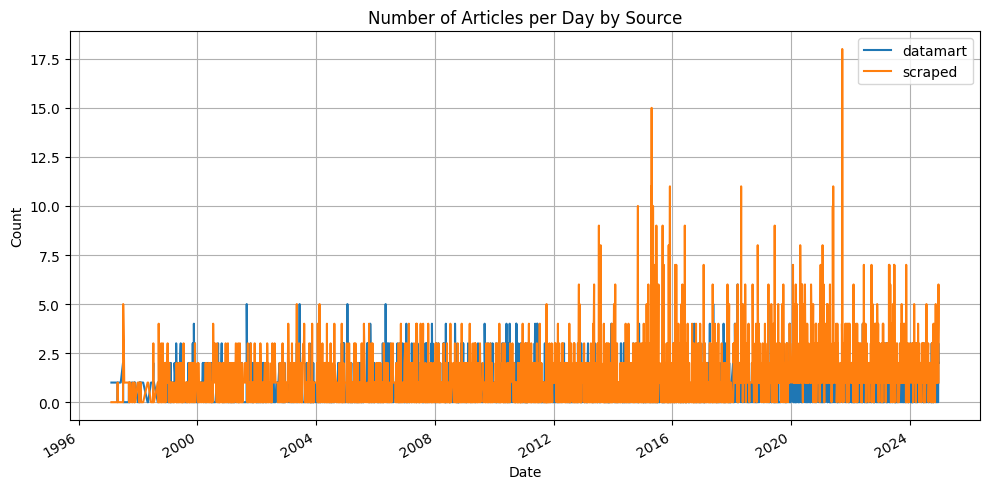

In [108]:
import polars as pl
import matplotlib.pyplot as plt

# Example: df has columns: date (pl.Date) and category (str)
# Aggregate counts per date & category

df_all = pl.concat([df_sub.select(['date', 'source']), datamart.select(['date', 'source'])])
counts = (
    df_all.group_by(["date", "source"])
      .len()
      .rename({"len": "count"})
      .sort("date")
)

# Pivot so each category is its own series
pivoted = counts.pivot(
    values="count",
    index="date",
    columns="source"
).fill_null(0)

# Plot
pivoted_df = pivoted.to_pandas()
pivoted_df["date"] = pd.to_datetime(pivoted_df["date"])     # safe-guard
pivoted_df = pivoted_df.set_index("date").sort_index()
pivoted_df.plot(kind="line", figsize=(10, 5))
plt.title("Number of Articles per Day by Source")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
pl.read_parquet(r"data\blogs_articles\parsed_ecb_articles_by_year.parquet")

date,category,title,filter_type,url,filter_value,url_hash,html_downloaded,download_error,index,path_to_html,text,error,authors
date,str,str,str,str,list[str],u64,bool,str,u64,str,str,str,list[str]
1992-04-01,"""Annual Report""","""Annual Report 1991""","""year""","""https://www.ecb.europa.eu/pub/…","[""1992""]",2591984009577538591,true,null,0,"""C:\Users\povhi\OneDrive\01_Uni…","""""",null,"[""Committe Of Governors Of The Central Banks Of The Member States Of The European Economic Community""]"


In [12]:
import polars as pl
df = pl.read_parquet(r'data\blogs_articles\parsed_ecb_articles_by_year.parquet')

df['url'].value_counts().max()

url,count
str,u32
"""https://www.ecb.europa.eu/stat…",4
